# Imports

In [66]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import datetime
import time
import re
import matplotlib.pyplot as plt
from pprint import pprint

In [67]:
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

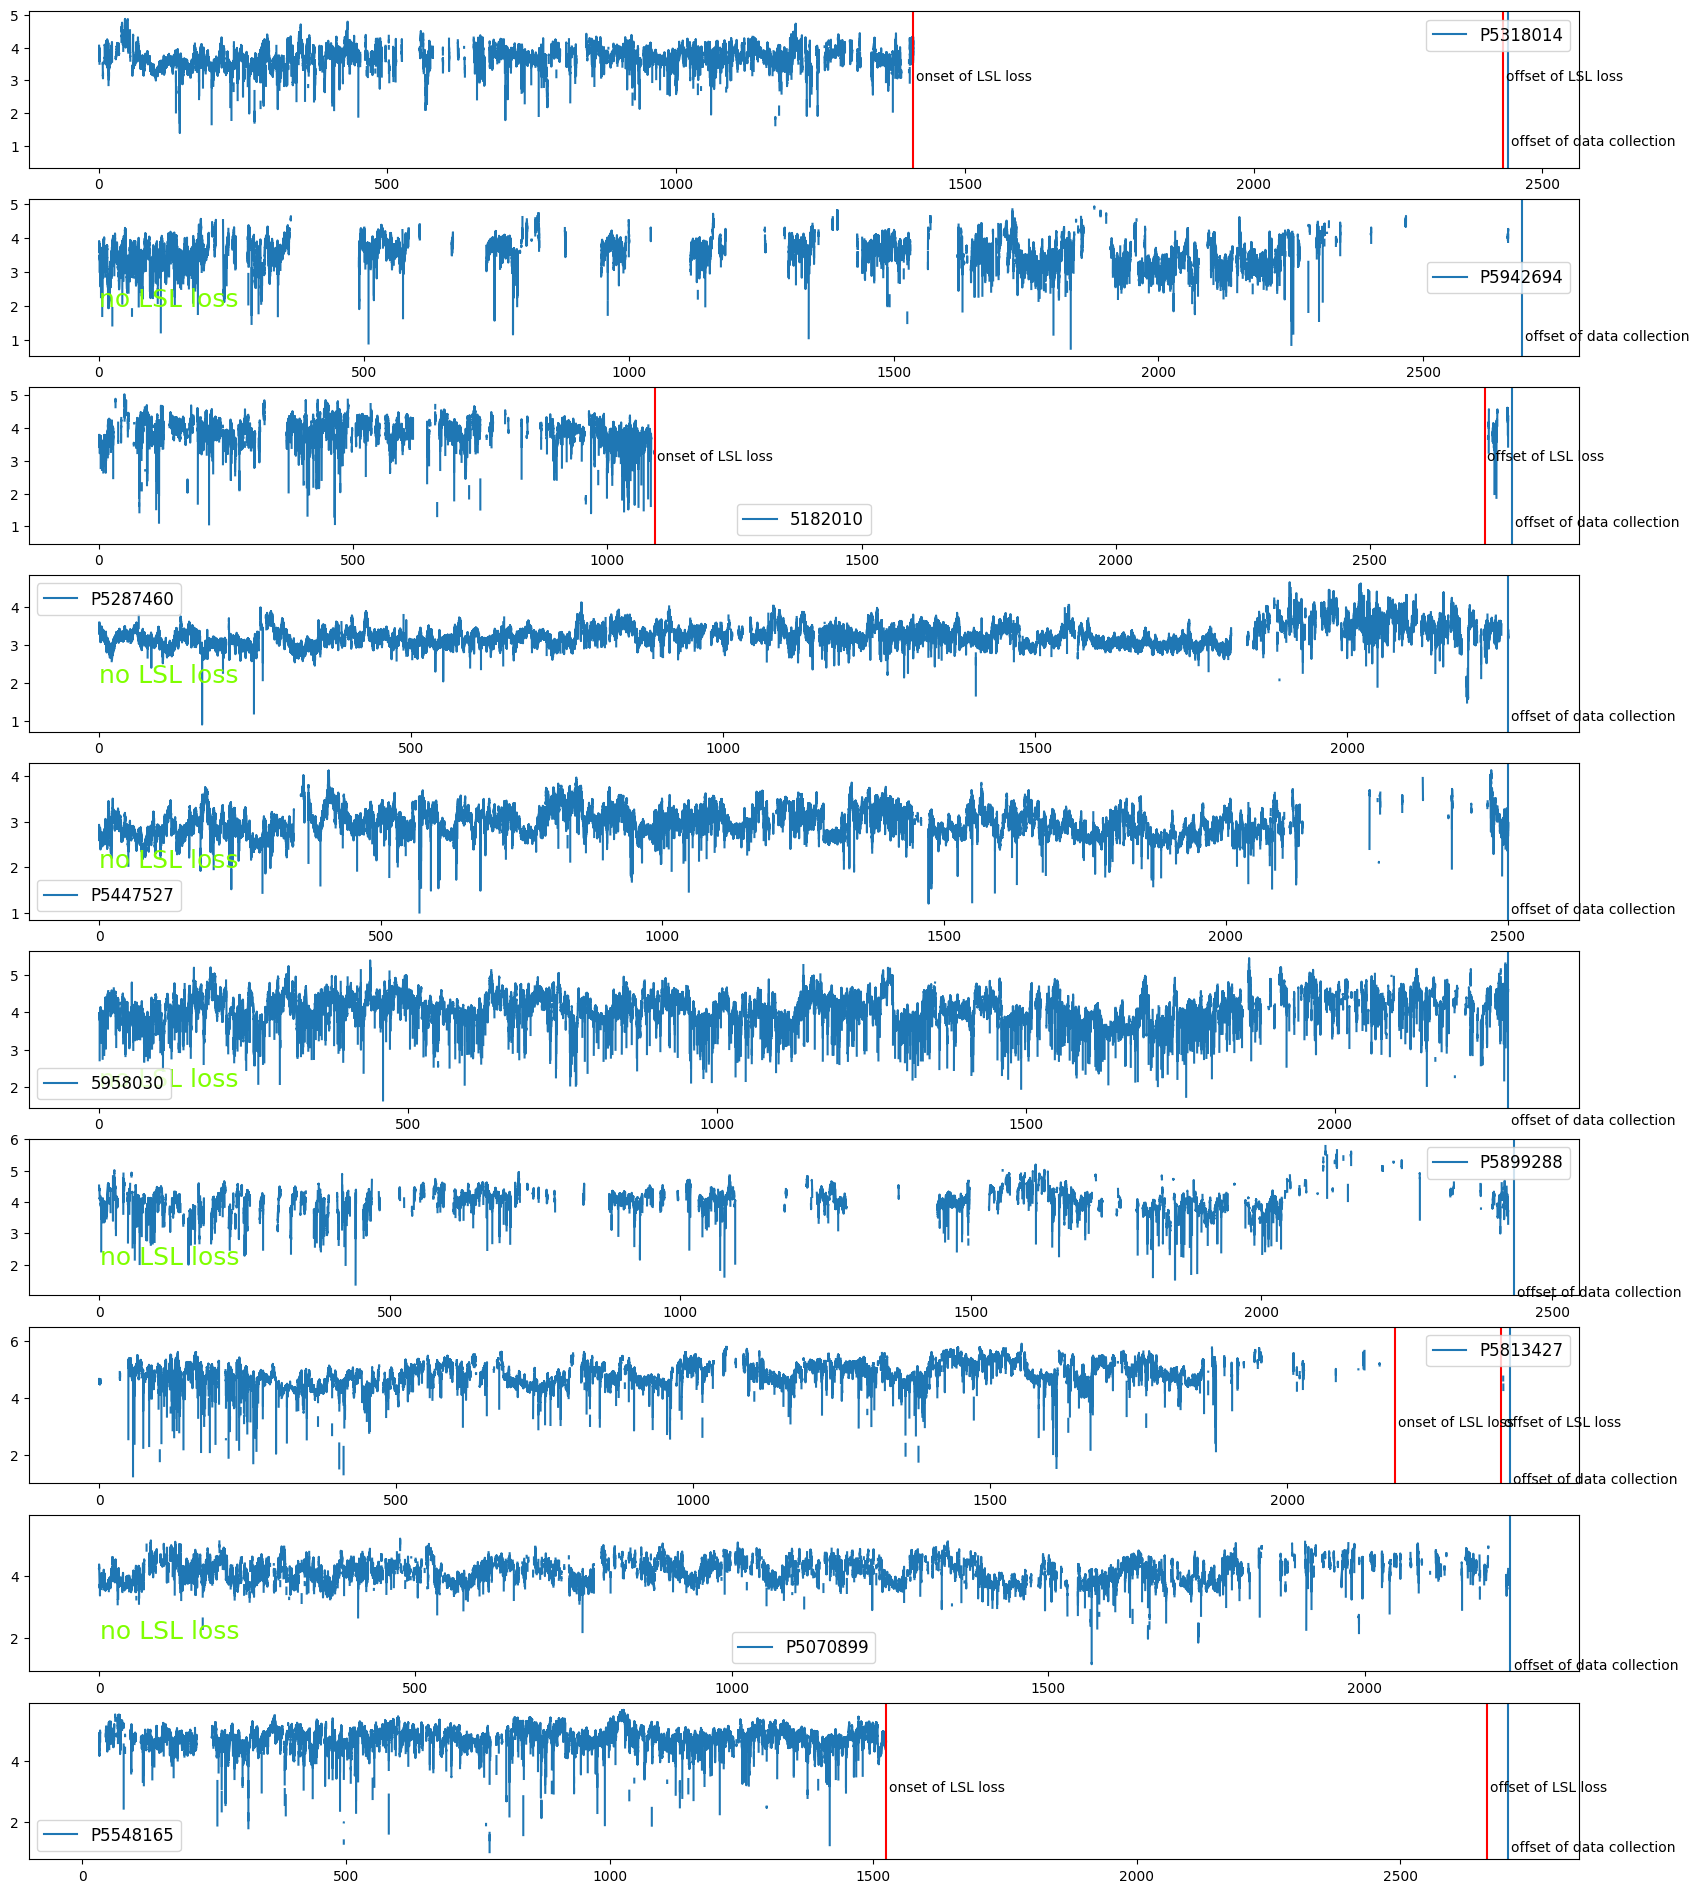

In [49]:
# plot onset + offset of LSL loss + offset of data collection
sub_files = glob('../../../Data/*/*.xdf')
fig, ax = plt.subplots(figsize=(20,24), nrows=len(sub_files), ncols=1)
sub_names = {}

for i in range(len(sub_files)):
    sub_names[i] = sub_files[i].split('/')[4].split('-')[1]

    # load in data
    xdf_path = sub_files[i]
    data, header = pyxdf.load_xdf(xdf_path, select_streams=[{'type':'ET'}])
    streams_collected = [stream['info']['name'][0] for stream in data]

    ET = data[streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]
    et_df = pd.DataFrame(data=et_dat, columns=column_labels)
    et_df['lsl_time_stamp'] = ET['time_stamps']
    et_df['diff'] = et_df['lsl_time_stamp'].diff()
    et_df['time'] = (et_df['lsl_time_stamp'] - et_df['lsl_time_stamp'][0])

    # print(et_df['time'])

     
    srate = ET['info']['effective_srate']
    index = np.where(et_df['diff'] > (1/srate + 1e-2))[0]

    ax[i].plot(et_df['time'], et_df['right_pupil_diameter'], label = sub_names[i])
    ax[i].axvline(et_df['time'].values[-1])
    ax[i].text(et_df['time'].values[-1]+5, 1, 'offset of data collection')

    if len(index) == 0:
        ax[i].text(et_df['time'][100], 2, 'no LSL loss', color = 'chartreuse', fontsize = 18)
    else:
        ax[i].axvline(et_df['time'][index[0]-1], color = 'r')
        ax[i].text(et_df['time'][index[0]-1]+5, 3, 'onset of LSL loss')
        ax[i].axvline(et_df['time'][index[0]], color = 'r')
        ax[i].text(et_df['time'][index[0]]+5, 3, 'offset of LSL loss')


    ax[i].legend(fontsize = 'large')

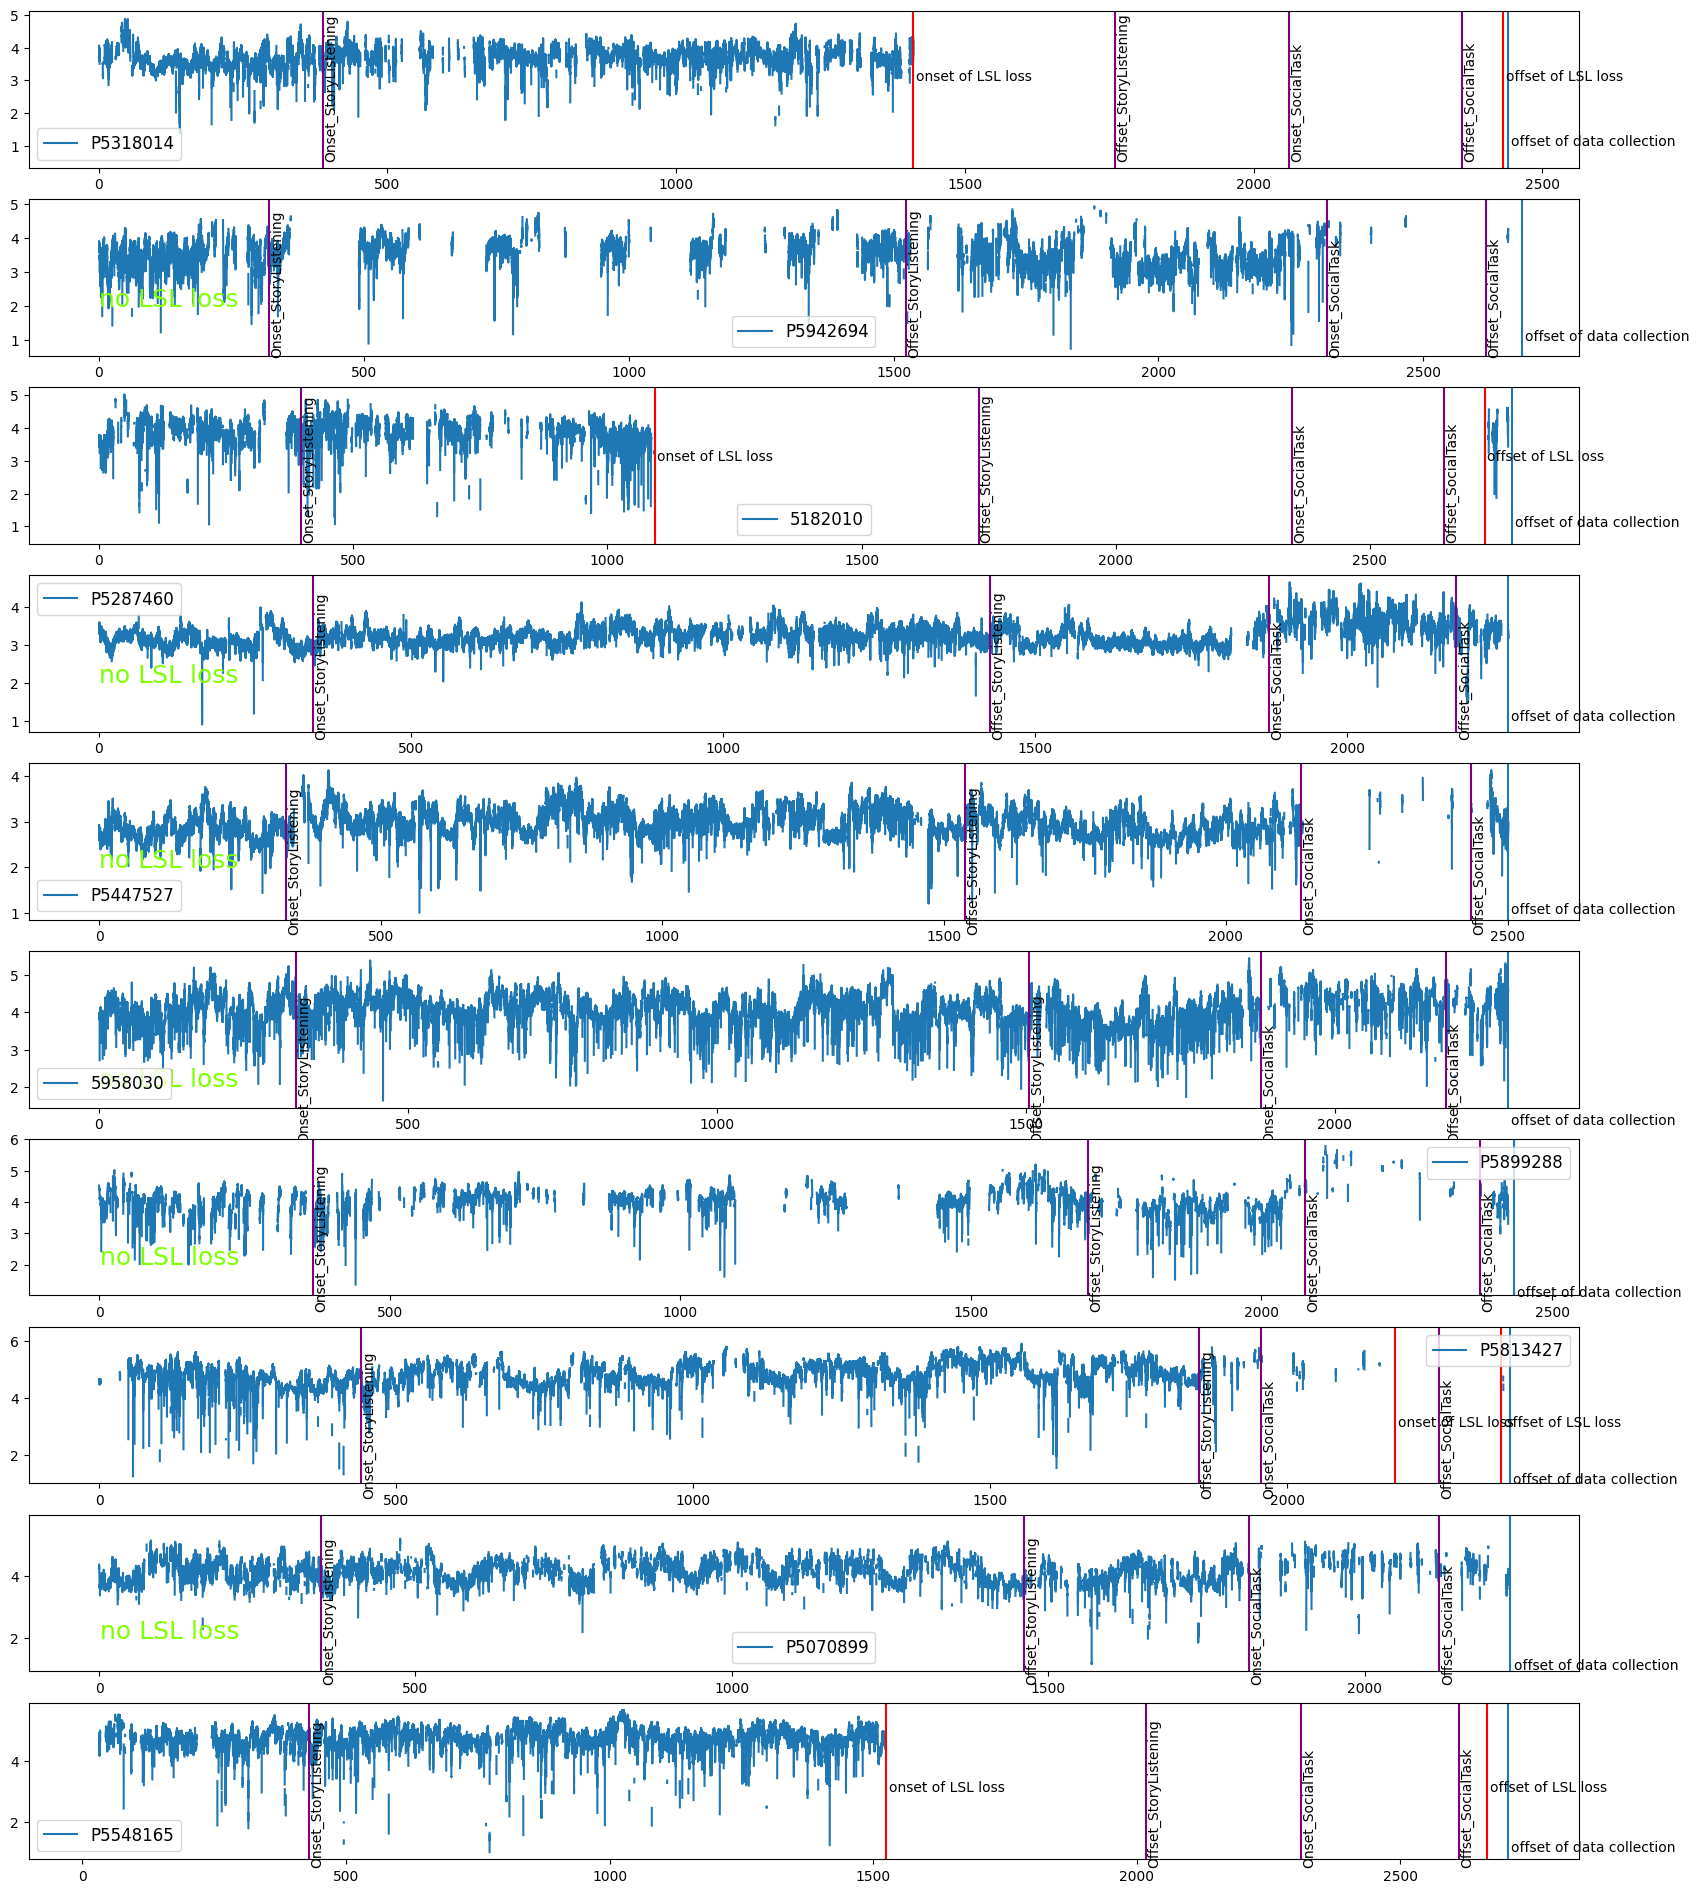

In [68]:
# plot LSL loss,onset + offset of experiment parts
sub_files = glob('../../../Data/*/*.xdf')
fig, ax = plt.subplots(figsize=(20,24), nrows=len(sub_files), ncols=1)
sub_names = {}

for i in range(len(sub_files)):
    sub_names[i] = sub_files[i].split('/')[4].split('-')[1]

    # load in data
    xdf_path = sub_files[i]
    data, header = pyxdf.load_xdf(xdf_path, select_streams=[{'type':'ET'}, {'type': 'Markers'}])
    streams_collected = [stream['info']['name'][0] for stream in data]

    ET = data[streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]
    et_df = pd.DataFrame(data=et_dat, columns=column_labels)
    et_df['lsl_time_stamp'] = ET['time_stamps']
    et_df['diff'] = et_df['lsl_time_stamp'].diff()
    et_df['time'] = (et_df['lsl_time_stamp'] - et_df['lsl_time_stamp'][0])

    # stim
    stim_dat = data[streams_collected.index('Stimuli_Markers')]
    stim_df = pd.DataFrame(stim_dat['time_series'])
    stim_df.rename(columns={0: 'trigger'}, inplace=True)
    stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')
    stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
    stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
    stim_df['diff'] = stim_df['lsl_time_stamp'].diff()
    stim_df['time'] = stim_df['lsl_time_stamp'] - et_df['lsl_time_stamp'][0]


     
    srate = ET['info']['effective_srate']
    # index where et_df 
    index = np.where(et_df['diff'] > (1/srate + 1e-2))[0]

    ax[i].plot(et_df['time'], et_df['right_pupil_diameter'], label = sub_names[i])
    ax[i].axvline(et_df['time'].values[-1])
    ax[i].text(et_df['time'].values[-1]+5, 1, 'offset of data collection')
    
    for event in stim_df.loc[stim_df.event.str.contains('StoryListening|SocialTask')].iterrows():
        ax[i].axvline(event[1]['time'], color='purple') # timestamp
        ax[i].text(event[1]['time']+2, .6, event[1]['event'], rotation=90)

    if len(index) == 0:
        ax[i].text(et_df['time'][100], 2, 'no LSL loss', color = 'chartreuse', fontsize = 18)
    else:
        ax[i].axvline(et_df['time'][index[0]-1], color = 'r')
        ax[i].text(et_df['time'][index[0]-1]+5, 3, 'onset of LSL loss')
        ax[i].axvline(et_df['time'][index[0]], color = 'r')
        ax[i].text(et_df['time'][index[0]]+5, 3, 'offset of LSL loss')


    ax[i].legend(fontsize = 'large')